# Implementing Relaxation

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Let's start by writing a grid class that holds the solution and RHS and knows how to fill ghost cells.  Much of this class is identical to what we've done before.

In [3]:
class Grid:
    def __init__(self, nx, ng=1, xmin=0, xmax=1,
                 bc_left_type="dirichlet", bc_left_val=0.0,
                 bc_right_type="dirichlet", bc_right_val=0.0):

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx
        
        self.bc_left_type = bc_left_type
        self.bc_left_val = bc_left_val
        
        self.bc_right_type = bc_right_type
        self.bc_right_val = bc_right_val
        
        # python is zero-based.  Make easy integers to know where the
        # real data lives
        self.ilo = ng
        self.ihi = ng+nx-1

        # physical coords -- cell-centered
        self.dx = (xmax - xmin)/(nx)
        self.x = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx

        # storage for the solution
        self.phi = self.scratch_array()
        self.f = self.scratch_array()
        
    def scratch_array(self):
        """return a scratch array dimensioned for our grid """
        return np.zeros((self.nx+2*self.ng), dtype=np.float64)

    def fill_bcs(self):
        """fill the boundary conditions on phi"""
        
        # we only deal with a single ghost cell here
        
        # left
        if self.bc_left_type.lower() == "dirichlet":
            self.phi[self.ilo-1] = 2 * self.bc_left_val - self.phi[self.ilo]
        elif self.bc_left_type.lower() == "neumann":
            self.phi[self.ilo-1] = self.phi[self.ilo] - self.dx * self.bc_left_val
        else:
            raise ValueError("invalid bc_left_type")
            
        # right
        if self.bc_right_type.lower() == "dirichlet":
            self.phi[self.ihi+1] = 2 * self.bc_right_val - self.phi[self.ihi]
        elif self.bc_right_type.lower() == "neumann":
            self.phi[self.ihi+1] = self.phi[self.ihi] - self.dx * self.bc_right_val
        else:
            raise ValueError("invalid bc_right_type")

Next we'll write a smoother routine, that does a single pass of red-black G-S.  Notice that we first update zones `ilo`, `ilo+2`, `ilo+4`, ... and then we need to fill the ghost cells with our boundary conditions again.  Then we do the next sweep, this time updating `ilo+1`, `ilo+3`, `ilo+5`, ...

In [4]:
def smooth(g):
    """perform red-black Gauss-Seidel smoothing"""
    
    g.fill_bcs()
    
    g.phi[g.ilo:g.ihi+1:2] = 0.5 * (-g.dx * g.dx * g.f[g.ilo:g.ihi+1:2] +
                                    g.phi[g.ilo+1:g.ihi+2:2] + g.phi[g.ilo-1:g.ihi:2])
    
    g.fill_bcs()

    g.phi[g.ilo+1:g.ihi+1:2] = 0.5 * (-g.dx * g.dx * g.f[g.ilo+1:g.ihi+1:2] +
                                      g.phi[g.ilo+2:g.ihi+2:2] + g.phi[g.ilo:g.ihi:2])

Now we are ready to try this out.  Let's do the problem:

$$\phi^{\prime\prime} = \sin(x)$$

on $[0, 1]$ with homogeneous Dirichlet BCs.

The solution is:

$$\phi(x) = -\sin(x) + x \sin(1)$$

Let's create functions that initialize the RHS and the analytic solution.

In [5]:
def analytic(x):
    return -np.sin(x) + x * np.sin(1.0)

def f(x):
    return np.sin(x)

Now let's create the grid&mdash;we'll use 128 points to start.  The defaults for the grid class already set homogeneous Dirichlet BCs.

In [6]:
g = Grid(128)

Now we need to initialize $\phi$ and $f$.  

For $\phi$, we may as well just initialize it to $0$ (which is already done for us by the grid class), since usually we don't know what the answer is.

In [7]:
g.f[:] = f(g.x)

Now we can do relaxation / smoothing.  We don't know how many smoothing iterations we need, and we also haven't yet discussed how to determine what the error is / when to stop.  So we'll look at the result after a fixed number of smoothing iterations.

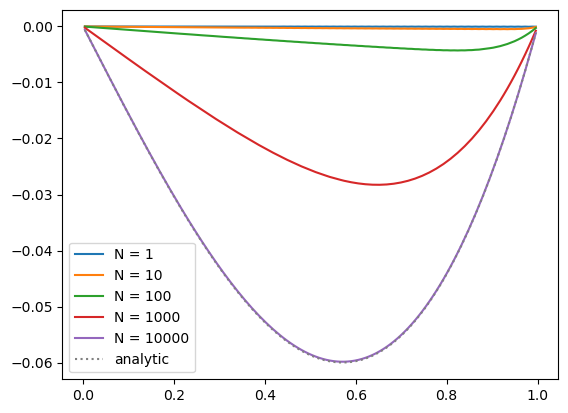

In [8]:
fig, ax = plt.subplots()

niters = [1, 10, 100, 1000, 10000]

for n in niters:

    # smooth n times
    for _ in range(n):
        smooth(g)
    
    ax.plot(g.x[g.ilo:g.ihi+1], g.phi[g.ilo:g.ihi+1], label=f"N = {n}")
    
    # reset phi to 0 for the next number of iterations
    g.phi[:] = 0.0

ax.plot(g.x[g.ilo:g.ihi+1], analytic(g.x[g.ilo:g.ihi+1]), ls=":",
        color="0.5", label="analytic")

ax.legend()

We see that as we increase the number of smoothing iterations, we get closer to the analytic solution.  Also note that the solution appears to be respecting our boundary conditions well.

It looks like only after 10000 iterations do we get close to the solution.

<div class="alert alert-block alert-info">

**In-class exercise:**
    
Code up Jacobi relaxation and see how it compares to G-S on this problem.
</div>